In [1]:
## set wd to the Git root directory
import os
os.chdir("..")
##
from src.models import sub_model
from src.utils import model_utils, model_evaluation
from gensim.models import KeyedVectors
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

2025-01-08 00:53:43.541767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 00:53:43.679696: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
model_save_path = "data/external/models" 
file_path = "data/processed"

data_x = pd.read_csv(file_path + "/all_U2_U12_x.txt.gz", compression='gzip', sep = " ", header = None)
data_x_5_dist = pd.read_csv(file_path + "/all_U2_U12_x_5_distance.txt.gz", compression='gzip', sep = " ", header = None)
data_x_3_dist = pd.read_csv(file_path + "/all_U2_U12_x_3_distance.txt.gz", compression='gzip', sep = " ", header = None)
data_y = pd.read_csv(file_path + "/all_U2_U12_y.txt.gz", compression='gzip', sep = " ", header = None)
data_type = pd.read_csv(file_path + "/all_U2_U12_info.txt.gz", compression='gzip', sep = " ", header = 0)
data_y_target = data_y.to_numpy()
data_y_target = tf.cast(data_y_target, dtype = tf.float32)

## OH encoding
data_x_oh = tf.convert_to_tensor(data_x.iloc[:,0:70].to_numpy(), dtype = tf.string)

string2int_layer = tf.keras.layers.StringLookup(vocabulary = ["A", "T", "C", "G"], output_mode='int')
data_x_oh = string2int_layer(data_x_oh)
data_x_oh = tf.one_hot(data_x_oh - 1, depth = 4, on_value = 1, off_value = 0)
data_x_oh = tf.cast(data_x_oh, dtype = tf.float32)
##

## Kmers encoding
data_x_kmers = model_utils.kmers_join(data_x, kmer = 3)

vocab_tmp = []
vocab = []
for one in "ATCGN":
    for two in "ATCGN":
        for three in "ATCGN":
            vocab_tmp.append(one + two + three)

for i in vocab_tmp:
    if i[1] != "N":
        if i[0] != "N" and i[2] != "N":
            vocab.append(i)
        if i[0] == "N" and i[2] != "N":
            vocab.append(i)
        if i[0] != "N" and i[2] == "N":
            vocab.append(i)

string2int_embed_layer = tf.keras.layers.StringLookup(vocabulary = vocab, output_mode='int')
data_x_kmers_embedding = string2int_embed_layer(data_x_kmers) - 1
##

## word2vec encoding
wv = KeyedVectors.load(model_save_path + "/word2vec_gencode_v19.3mers", mmap='r')
data_x_word2vec_embedding = []
for row in data_x_kmers:
    tmp = []
    for key in row:
        tmp.append(wv[key])
    data_x_word2vec_embedding.append(tmp)

data_x_word2vec_embedding = np.array(data_x_word2vec_embedding)
##

u2_index = (data_type.iloc[:,2] == "U2").to_numpy()
u12_index = (data_type.iloc[:,2] == "U12").to_numpy()
test_index = (data_type.iloc[:,3] == "test").to_numpy()

## test
X_add_distance_U2_test = np.concatenate((
                          data_x_5_dist.to_numpy().reshape((-1, 70, 1))[np.logical_and(test_index, u2_index)],
                          data_x_3_dist.to_numpy().reshape((-1, 70, 1))[np.logical_and(test_index, u2_index)]),
                          axis = -1)

X_add_distance_U12_test = np.concatenate((
                          data_x_5_dist.to_numpy().reshape((-1, 70, 1))[np.logical_and(test_index, u12_index)],
                          data_x_3_dist.to_numpy().reshape((-1, 70, 1))[np.logical_and(test_index, u12_index)]),
                          axis = -1)                        

X_test_U2_oh = data_x_oh[np.logical_and(test_index, u2_index)]
X_test_U2_kmers = data_x_kmers_embedding[np.logical_and(test_index, u2_index)]
X_test_U2_word2vec = data_x_word2vec_embedding[np.logical_and(test_index, u2_index)]

X_test_U12_oh = data_x_oh[np.logical_and(test_index, u12_index)]
X_test_U12_kmers = data_x_kmers_embedding[np.logical_and(test_index, u12_index)]
X_test_U12_word2vec = data_x_word2vec_embedding[np.logical_and(test_index, u12_index)]

y_test_U2 = tf.reshape(data_y_target, (-1, 70, 1))[np.logical_and(test_index, u2_index)]
y_test_U12 = tf.reshape(data_y_target, (-1, 70, 1))[np.logical_and(test_index, u12_index)]
##

2025-01-08 00:53:54.039083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 00:53:54.158989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22987 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [3]:
print(X_test_U2_oh.shape)
print(X_test_U2_kmers.shape)
print(X_test_U2_word2vec.shape)
print(X_add_distance_U2_test.shape)
print(y_test_U2.shape)
print()
print(X_test_U12_oh.shape)
print(X_test_U12_kmers.shape)
print(X_test_U12_word2vec.shape)
print(X_add_distance_U12_test.shape)
print(y_test_U12.shape)

(13942, 70, 4)
(13942, 70)
(13942, 70, 100)
(13942, 70, 2)
(13942, 70, 1)

(56, 70, 4)
(56, 70)
(56, 70, 100)
(56, 70, 2)
(56, 70, 1)


In [4]:
X_test_U2_pred = model_evaluation.model_pred(model_path = [model_save_path + '/all_U2_oh.h5', 
                                                           model_save_path + '/all_U2_kmers.h5', 
                                                           model_save_path + '/all_U2_word2vec.h5'], 
                                             input = [(X_test_U2_oh, X_add_distance_U2_test), 
                                                      (X_test_U2_kmers, X_add_distance_U2_test), 
                                                      (X_test_U2_word2vec, X_add_distance_U2_test)], 
                                             ensemble = True, ensemble_weight = 1/3, 
                                             custom_objects = {'SelfAttention':sub_model.SelfAttention})

2025-01-08 00:54:27.597687: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2025-01-08 00:54:27.733121: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-08 00:54:27.740978: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-08 00:54:27.741012: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-01-08 00:54:27.743493: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-08 00:54:27.743534: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [5]:
X_test_U12_pred = model_evaluation.model_pred(model_path = [model_save_path + '/all_U12_oh.h5', 
                                                            model_save_path + '/all_U12_kmers.h5', 
                                                            model_save_path + '/all_U12_word2vec.h5'], 
                                              input = [(X_test_U12_oh, X_add_distance_U12_test), 
                                                       (X_test_U12_kmers, X_add_distance_U12_test), 
                                                       (X_test_U12_word2vec, X_add_distance_U12_test)], 
                                              ensemble = True, ensemble_weight = 1/3, 
                                              custom_objects = {'SelfAttention':sub_model.SelfAttention})

In [6]:
print(X_test_U2_pred.shape)
print(X_test_U12_pred.shape)

(13942, 70, 1)
(56, 70, 1)


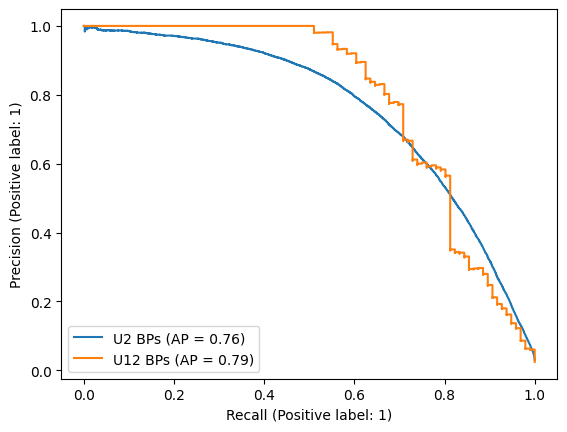

In [7]:
ax = plt.gca()

PrecisionRecallDisplay.from_predictions(y_test_U2.numpy().reshape(-1),
                                        X_test_U2_pred.reshape(-1),
                                        ax = ax, 
                                        name='U2 BPs')

PrecisionRecallDisplay.from_predictions(y_test_U12.numpy().reshape(-1),
                                        X_test_U12_pred.reshape(-1),
                                        ax = ax, 
                                        name='U12 BPs')
plt.show()                                    